# Project Fresh
### Finding and Targeting Instacart's Top User Group

This notebook details the approaches and the conclusions of
Project Fresh which aims to find and target Instacart's top consumer group

<b>This notebook covers:</b>
1. Data Cleaning
2. EDA
3. Clustering
3. Recommendations

<b>Our Approach:</b>
1. First step is to find the highest value consumer group using K-Means on previous purchase behavior.
2. After checking for the purity of the groups, we count the # of orders per group and the avg items per order to calculate their value.


<b> Recommendations:</b>


<b> Next Steps:</b>
1. Try Other Algorithms
2. Use Products Instead of Departments
3. Build a Dashboard for automated insights

### Aside from that, I hope you enjoy this notebook!

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [10]:
# Make all my plots 538 Style
plt.style.use('fivethirtyeight')

In [5]:
order_products_train_df = pd.read_csv("../order_products__train.csv")
order_products_prior_df = pd.read_csv("../order_products__prior.csv")
orders_df = pd.read_csv("../orders.csv")
products_df = pd.read_csv("../products.csv")
aisles_df = pd.read_csv("../aisles.csv")
departments_df = pd.read_csv("../departments.csv")

prior_orders = orders_df[orders_df.eval_set == 'prior']

# 1. EDA

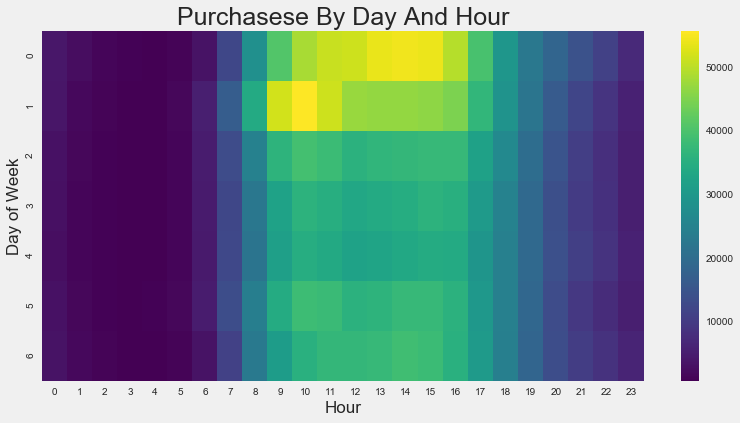

In [6]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df, cmap = 'viridis')
plt.title('Purchasese By Day And Hour', size = 25 )
plt.ylabel('Day of Week',size = 17)
_ = plt.xlabel('Hour',size = 17)

<b> Takeaways:</b>
1. There is more orders in the weekends and in between 7 and 6pm.

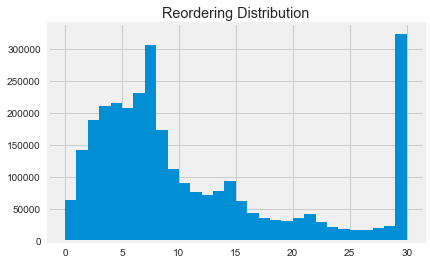

In [14]:
prior_orders.days_since_prior_order.hist(bins = 30)
plt.title('Reordering Distribution')

<b> Takeaways:</b>
1. Folks then to reorder in week or monthly increments.

In [21]:
pt1 = pd.merge(order_products_prior_df,products_df, on = 'product_id')[['order_id', 'department_id']]

In [37]:
complete_raw = pd.merge(pt1,prior_orders, on = 'order_id')

In [38]:
complete_raw.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0


In [47]:
complete = complete_raw.groupby(['user_id','department_id' ]).count().reset_index()[['user_id','department_id' ]]

In [69]:
complete.head()

,user_id,department_id
0,1,4
1,1,7
2,1,13
3,1,14
4,1,16


# 2. Costumer Segmentation

#### Creating a Dataframe to Segment

In [88]:
column_dict = {}
user_col = []
for i in range(1,22):
    column_dict[i] = []

    
print  datetime.now().strftime('%Y-%m-%d %H:%M:%S')

count = 0
for user in list(set(complete.user_id))[:15000]:
    count += 1
    departments = range(1,22)
    dept_user = set(complete[complete.user_id == user].department_id)
    
    for i in departments:
        if i in dept_user:
            column_dict[i].extend([1])
            
        else:
            column_dict[i].extend([0])
            
    
    user_col.append(user)
    if (count % 1000) == 0:
        print count
        print  datetime.now().strftime('%Y-%m-%d %H:%M:%S')

2018-07-29 18:39:34
1000
2018-07-29 18:39:38
2000
2018-07-29 18:39:42
3000
2018-07-29 18:39:46
4000
2018-07-29 18:39:50
5000
2018-07-29 18:39:54
6000
2018-07-29 18:39:58
7000
2018-07-29 18:40:02
8000
2018-07-29 18:40:06
9000
2018-07-29 18:40:10
10000
2018-07-29 18:40:14
11000
2018-07-29 18:40:18
12000
2018-07-29 18:40:22
13000
2018-07-29 18:40:26
14000
2018-07-29 18:40:29
15000
2018-07-29 18:40:33


In [89]:
clustering = pd.DataFrame(column_dict)

In [90]:
clustering.shape

(15000, 21)

In [91]:
clustering.head()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,0,0,0,1,0,0,1,0,0,0,...,0,1,1,0,1,1,0,1,0,0
1,1,0,1,1,0,1,1,0,0,0,...,1,1,1,1,1,0,0,1,1,0
2,1,0,0,1,0,0,1,0,1,0,...,0,1,0,0,1,1,0,1,1,0
3,1,0,1,1,1,0,1,0,0,0,...,0,0,0,1,0,1,0,1,1,0
4,1,0,0,1,0,1,0,0,1,0,...,0,1,0,1,1,0,0,1,1,0


### Implementing K-Means

In [92]:
from sklearn.cluster import KMeans
import numpy as np


X = clustering
#kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

In [93]:
cluster_range = range( 1, 20 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( X )
    cluster_errors.append( clusters.inertia_ )

In [94]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )


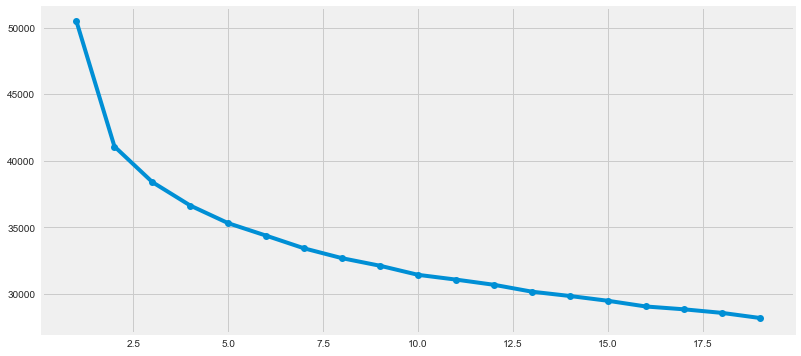

In [95]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [96]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

In [113]:
pt1 = complete[complete.user_id.isin(list(set(complete.user_id))[:15000])]

In [127]:
pt2 = pd.DataFrame({'user_id': list(set(pt1.user_id)) , 'clusters' : kmeans.labels_  })[['user_id', 'clusters'] ]

In [128]:
pt3 = pd.merge(pt1, pt2, on=[ 'user_id'])

In [134]:
pt4 = pd.merge(pt3, departments_df, on=[ 'department_id'])

In [135]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


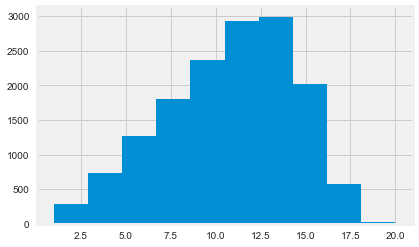

In [150]:
pt4.groupby('user_id').count()['department_id'].hist()

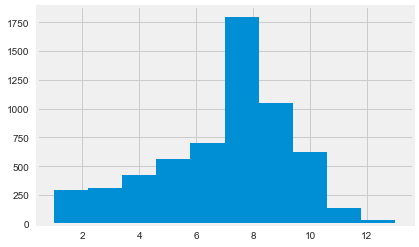

In [151]:
pt4[pt4.clusters == 0].groupby('user_id').count()['department_id'].hist()

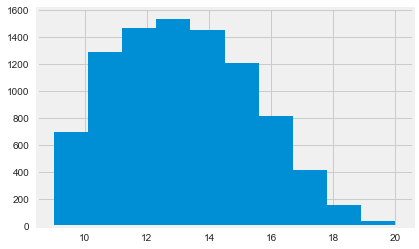

In [152]:
pt4[pt4.clusters == 1].groupby('user_id').count()['department_id'].hist()